In [1]:
import os
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from SiameseModel import Recognizer
from matplotlib import pyplot as plt

#RAW_DATA_DIR = r'C:\Users\Marti\Documents\Master Thesis\PMData'
RAW_DATA_DIR = r'/work/martiks/PMData'
PARTICIPANTS = os.listdir(RAW_DATA_DIR) # Not including the .xlsx file
PARTICIPANTS = [p for p in PARTICIPANTS if ".xlsx" not in p]
MAX_WEEKS = 14
CHUNK_SIZE = {
    'heart_rate': 17280, #86400, #day=86400, week=604800
    'step': 10080
}

# Convert to taking inputs for these parameters.
DATA_TYPE = "heart_rate" # step, heart_rate

NUM_PARTICIPANTS = 16
assert (1 <= NUM_PARTICIPANTS <= 16), "Number of participants must be between 1-16"

NUM_WEEKS = 7 # NOTE: this is actually days now, not weeks
assert_msg = f"Number of weeks must be between 1-{MAX_WEEKS}"
#assert (1 <= NUM_WEEKS <= MAX_WEEKS), assert_msg

START_WEEK = 0 # input - 1
assert_msg = f"Must be <= {MAX_WEEKS - NUM_WEEKS}"
#assert (START_WEEK <= (MAX_WEEKS - NUM_WEEKS)), assert_msg

TEST_NUM_WEEKS = 3
assert_msg = f"Must be <= {MAX_WEEKS - (START_WEEK + NUM_WEEKS)}"
#assert (TEST_NUM_WEEKS <= (MAX_WEEKS - (START_WEEK + NUM_WEEKS))), assert_msg

TEST_START_WEEK = START_WEEK + NUM_WEEKS

print("======================================================TEST START======================================================")
print(f"Parameters used: num_participants={NUM_PARTICIPANTS}, num_weeks={NUM_WEEKS}, start_week={START_WEEK}, test_num_weeks={TEST_NUM_WEEKS}, test_start_week={TEST_START_WEEK}")

======================================================TEST START======================================================
Parameters used: num_participants=16, num_weeks=7, start_week=0, test_num_weeks=3, test_start_week=7


In [2]:
def read_file(maindir, p, file):
    path = f"{maindir}/{p}/fitbit/{file}"
    if ".json" in file:
        return pd.read_json(path)
    elif ".csv" in file:
        return pd.read_csv(path) # TODO: verify that pandas reads the PMData csv files properly
    else:
        raise TypeError("Unsupported file type!")


def clean_data_hr(df, start_date="2019-11-18 00:00:00", end_date="2020-02-23 23:59:59"):
    # Preserve datetime as index
    df['dateTime'] = pd.to_datetime(df['dateTime'])
    index = df['dateTime']
    
    # Convert dict-values to columns and set datetimes as index
    df = pd.DataFrame.from_dict(df.value.to_dict(), orient='index')
    df = df.set_index(index)

    # Check if start_date and end_date rows exist (create if not)
    if not start_date in df.index:
        stamp = pd.Timestamp(start_date)
        df.loc[stamp] = None
    if not end_date in df.index:
        stamp = pd.Timestamp(end_date)
        df.loc[stamp] = None
    
    # Sort chronologically using datetime-index
    df = df.sort_index()

    # Shave off incomplete weeks at start/end
    df = df.loc[start_date:end_date] # Adjust dates as necessary

    # Fill in missing rows to make data set consistent (secondly)
    df = df.resample('1s').first()

    # Interpolate, round off and cast to int
    df['bpm'] = df.bpm.interpolate(method='linear', limit_direction='both').round(0).astype(np.int32)
    
    # Resample back to 5-second frequency
    df = df.resample('5s').first()

    # Add day of the week features
    df = df.reset_index()
    df['weekday'] = df['dateTime'].dt.dayofweek
    df['mon'] = df['weekday'].apply(lambda x: 1 if (x==0) else 0)
    df['tue'] = df['weekday'].apply(lambda x: 1 if (x==1) else 0)
    df['wed'] = df['weekday'].apply(lambda x: 1 if (x==2) else 0)
    df['thu'] = df['weekday'].apply(lambda x: 1 if (x==3) else 0)
    df['fri'] = df['weekday'].apply(lambda x: 1 if (x==4) else 0)
    df['sat'] = df['weekday'].apply(lambda x: 1 if (x==5) else 0)
    df['sun'] = df['weekday'].apply(lambda x: 1 if (x==6) else 0)

    # Remove unwanted columns
    del df['dateTime']
    del df['confidence']
    del df['weekday']
    
    return df

In [3]:
def prepare_chunks(datasets, start_week=0, weeks=5, no_ID=False):
    chunks = []
    start_ind = start_week * CHUNK_SIZE[DATA_TYPE] # Finds index corresponding to monday 00:00:00 of start_week
    for p in datasets:
        for i in range(weeks): # weeks mon-sun
            from_ind = start_ind + (CHUNK_SIZE[DATA_TYPE] * i)
            to_ind = from_ind + (CHUNK_SIZE[DATA_TYPE] - 1)
            chunk = p[1].loc[from_ind:to_ind]
            chunk = np.array(chunk)
            if no_ID:
                chunks.append(chunk)
            else:
                chunks.append((p[0], chunk))
    return chunks


def remove_ID(dataset):
    # Remove ID
    for i in range(len(dataset)):
        dataset[i] = dataset[i][1]

In [4]:
# DATA PROCESSING

datasets = []
for p in PARTICIPANTS[:NUM_PARTICIPANTS]:
    pdata = read_file(RAW_DATA_DIR, p, "heart_rate.json")
    d = clean_data_hr(pdata)
    tup = (p, d)
    datasets.append(tup)

# List with participant name and corresponding week-chunks
# [('p01', chunks_array), ('p02', chunks_array), ...]
chunks = prepare_chunks(datasets, start_week=START_WEEK, weeks=NUM_WEEKS)

In [5]:
# BALANCED VERSION
input_1 = []
input_2 = []
labels = []

# Match all chunks (balanced)
for i in range(len(chunks)):
    same = []
    not_same = []
    for j in range(len(chunks)):
        if chunks[j][0] == chunks[i][0]:
            same.append(chunks[j])
        else:
            not_same.append(chunks[j])
    random.shuffle(same)
    random.shuffle(not_same)
    not_same = not_same[:len(same)] # match lengths for balance
    to_add = same + not_same
    random.shuffle(to_add)
    input_2.extend(to_add)
    for x in range(len(to_add)):
        input_1.append(chunks[i])

In [6]:
# GENERATE LABELS AND REMOVE ID
for i in range(len(input_1)):
    # Check if they have the same ID
    p1 = input_1[i][0]
    p2 = input_2[i][0]
    if p1 == p2:
        labels.append(1)
    else:
        labels.append(0)
remove_ID(input_1)
remove_ID(input_2)
    
X1 = np.array(input_1)
X2 = np.array(input_2)
Y = np.array(labels)

In [7]:
# NEW - Separate into train and val data
chunk_len = len(X1)
train_len = int(chunk_len * 0.7)
X1_train = X1[:train_len]
X1_val = X1[train_len:]
X2_train = X2[:train_len]
X2_val = X2[train_len:]
Y_train = Y[:train_len]
Y_val = Y[train_len:]
# END NEW

In [8]:
# MODEL TRAINING

recognizer = Recognizer()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)

checkpoint_filepath = '/work/martiks/saved_models/new'
save_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True
)

parameters = {
    'batch_size' : 16 ,
    'epochs' : 5000 , # 5000 if callback is implemented
    'callbacks' : [early_stop, save_checkpoint] ,
    'val_data' : ([X1_val, X2_val], Y_val) #None
}

history = recognizer.fit([X1_train, X2_train], Y_train, hyperparameters=parameters)
#recognizer.fit([X1, X2], Y, hyperparameters=parameters)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 17217, 32)         16416     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 17154, 32)         65568     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 17091, 64)         131136    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 17028, 64)         262208    
_________________________________________________________________
dense (Dense)                (None, 17028, 64)         4160      
Total params: 479,488
Trainable params: 479,488
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5000
69/69 [==============================] - ETA: 0s - loss: 0.6797 - accuracy: 0.5803WARNING:tensorflow:Fr

In [25]:
# TESTING

def calc_scores_new(model, data_chunks, test_chunks):
    random.shuffle(data_chunks)
    random.shuffle(test_chunks)
    data_chunks = data_chunks[:len(test_chunks)] # match lengths
    truths = []
    for x, y in zip(data_chunks, test_chunks):
        if x[0] == y[0]:
            truths.append(1)
        else:
            truths.append(0)
    
    remove_ID(data_chunks)
    remove_ID(test_chunks)

    X = np.array(data_chunks)
    Y = np.array(test_chunks)

    scores = model.predict([X, Y])

    results = {
        'scores': scores,
        'truths': truths
    }

    return results

In [10]:
def print_scores_new(scores, truths):
    for i in range(len(scores)):
        print(f"Test {i} ground truth: {truths[i]}, predicted score: {scores[i]}")

In [20]:
def print_scores_avg(scores, truths):
    passed = 0
    for i in range(len(scores)):
        truth = truths[i]
        score = np.average(scores[i])
        test = "FAILED"
        if (truth == 0) and (0 <= score < 0.5):
            test = "PASSED"
            passed += 1
        elif (truth == 1) and (0.5 <= score <= 1):
            test = "PASSED"
            passed += 1
        print(f"Test {i} ground truth: {truth}, predicted score: {score}, test: {test}")
    print(f"Passed {passed} of {len(scores)} tests.")

In [22]:
loaded_recognizer = tf.keras.models.load_model('/work/martiks/saved_models/new')

In [35]:
shuffled_chunks = chunks.copy()
random.shuffle(shuffled_chunks)
test_chunks = prepare_chunks(datasets, start_week=TEST_START_WEEK, weeks=TEST_NUM_WEEKS)

In [36]:
results = calc_scores_new(loaded_recognizer, shuffled_chunks, test_chunks)
#print_scores_new(results['scores'], results['truths'])

In [37]:
print_scores_avg(results['scores'], results['truths'])

Test 0 ground truth: 0, predicted score: 0.08646532893180847, test: PASSED
Test 1 ground truth: 0, predicted score: 0.07703038305044174, test: PASSED
Test 2 ground truth: 0, predicted score: 0.4475150406360626, test: PASSED
Test 3 ground truth: 0, predicted score: 0.09008506685495377, test: PASSED
Test 4 ground truth: 0, predicted score: 0.320364385843277, test: PASSED
Test 5 ground truth: 0, predicted score: 0.2891139090061188, test: PASSED
Test 6 ground truth: 0, predicted score: 0.08755718916654587, test: PASSED
Test 7 ground truth: 0, predicted score: 0.4491077661514282, test: PASSED
Test 8 ground truth: 0, predicted score: 0.377890408039093, test: PASSED
Test 9 ground truth: 0, predicted score: 0.42940253019332886, test: PASSED
Test 10 ground truth: 0, predicted score: 0.5142374038696289, test: FAILED
Test 11 ground truth: 0, predicted score: 0.34875527024269104, test: PASSED
Test 12 ground truth: 0, predicted score: 0.46671584248542786, test: PASSED
Test 13 ground truth: 0, predi

=======================================================TEST END=======================================================


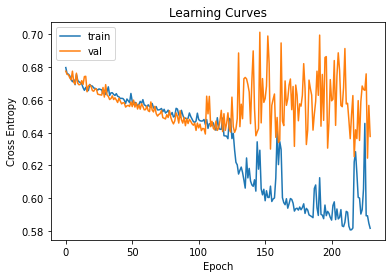

In [13]:
# plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.savefig('learning_curve.png')

print("=======================================================TEST END=======================================================")

In [ ]:
!tar chvfz notebook.tar.gz /saved_models/new *

tar: Removing leading `/' from member names
tar: /saved_models/new: Cannot stat: No such file or directory
hr_version.py
jupyter.sbatch
learning_curve_new.png
learning_curve.png
PMData/
PMData/participant-overview.xlsx
PMData/p01/
PMData/p01/fitbit/
PMData/p01/fitbit/calories.json
PMData/p01/fitbit/distance.json
PMData/p01/fitbit/exercise.json
PMData/p01/fitbit/lightly_active_minutes.json
PMData/p01/fitbit/moderately_active_minutes.json
PMData/p01/fitbit/resting_heart_rate.json
PMData/p01/fitbit/sedentary_minutes.json
PMData/p01/fitbit/sleep.json
PMData/p01/fitbit/sleep_score.csv
PMData/p01/fitbit/steps.json
PMData/p01/fitbit/time_in_heart_rate_zones.json
PMData/p01/fitbit/very_active_minutes.json
PMData/p01/fitbit/heart_rate.json
PMData/p01/pmsys/
PMData/p01/pmsys/injury.csv
PMData/p01/pmsys/srpe.csv
PMData/p01/pmsys/wellness.csv
PMData/p01/googledocs/
PMData/p01/googledocs/reporting.csv
PMData/p01/food-images/
PMData/p01/food-images/IMG_8916.jpeg
PMData/p01/food-images/IMG_8917.jpeg
